## Policy Evaluation

Let's try to evaluate a policy using exact algebraic method and Value iteration method.

The world and the policy are the following:

<img src="http://www.cs.upc.edu/~mmartin/Grid+world.jpg" width="350">

# 0. Defining the environment
## - Kind of states
Define state matrix for each cell: 1 means terminal state, 0 means normal state, -1 means impossible state

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#Define the state matrix
state_matrix = np.zeros((3,4))
state_matrix[0, 3] = 1
state_matrix[1, 3] = 1
state_matrix[1, 1] = -1
print("State Matrix:")
print(state_matrix)


State Matrix:
[[ 0.  0.  0.  1.]
 [ 0. -1.  0.  1.]
 [ 0.  0.  0.  0.]]


## - Reward function
Define reward matrix for each cell: All states -0.4, except for terminal states. Reward for corner terminal state is 1, for the other terminal state -1.

Reward Matrix:
[[-0.04 -0.04 -0.04  1.  ]
 [-0.04 -0.04 -0.04 -1.  ]
 [-0.04 -0.04 -0.04 -0.04]]


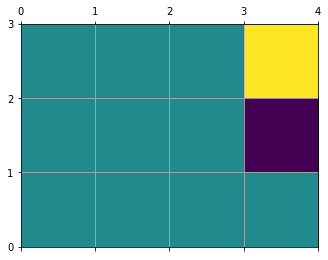

In [3]:
#Define the reward matrix
reward_matrix = np.full((3,4), -0.04)
reward_matrix[0, 3] = 1
reward_matrix[1, 3] = -1
print("Reward Matrix:")
print(reward_matrix)
plt.matshow(reward_matrix,extent=[0, 4, 0, 3])
plt.grid()
plt.show()

## - Definition of the policy and how to pretty-print it. 
Each action is represented by a number in the policy matrix. Action (Up) is represented by 0, (Rigth) by 1, (Down) by 2 and, finally, (Left) by 3. 

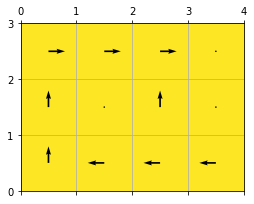

In [4]:
policy_matrix = np.array([[1,      1,  1,  -1],
                          [0, np.NaN,  0,  -1],
                          [0,      3,  3,   3]])

# Don't care about this function. Only prints the policy matrix
def print_policy(policy_matrix2, V=np.array([]),lstates=[]):
    """ Policy_matrix: is the policy to print
        V: is a value function that we want to superpose with colors to the policy
        lstates: is list of states to highligth if I want to stress something
    """
    policy_matrix = policy_matrix2[::-1]
    shape = policy_matrix.shape
    U=np.zeros(policy_matrix.shape)
    R=np.zeros(policy_matrix.shape)
    for row in range(shape[0]):
        for col in range(shape[1]):
            if(policy_matrix[row,col] == -1): 
                U[row,col]=0    
                R[row,col]=0  
            elif(policy_matrix[row,col] == 0): 
                U[row,col]=0    
                R[row,col]=1 
                #policy_string += " ^  "
            elif(policy_matrix[row,col] == 1): 
                U[row,col]=1   
                R[row,col]=0 
                #policy_string += " >  "
            elif(policy_matrix[row,col] == 2): 
                U[row,col]=0    
                R[row,col]=-1 
                #policy_string += " v  "           
            elif(policy_matrix[row,col] == 3):
                U[row,col]=-1   
                R[row,col]=0                 
                #policy_string += " <  "
            elif(np.isnan(policy_matrix[row,col])): 
                U[row,col]=0    
                R[row,col]=0  
                #policy_string += " #  "
    plt.rcParams['figure.figsize'] = (4,3)
    if V.size==0:
        V=np.ones(policy_matrix.shape)
        for x in lstates:
            V[x.multi_index]=0.7
        plt.matshow(V,extent=[0, 4, 0, 3],vmin=0, vmax=1)
    else:
        plt.matshow(V,extent=[0, 4, 0, 3])
    plt.grid()
    X, Y = np.meshgrid(np.arange(0.5, 4.5, 1), np.arange(0.5, 3.5, 1))
    Q = plt.quiver(X, Y,U,R)

    plt.show()

print_policy(policy_matrix)

## - Transition probabilities
We will represent transition probabilities with a matrix where each row represent the action executed, and column represent the probability of going to one direction. Column 0 represents direction Up, Column 1 represents direction Right, Column 2 represents direction Down and Column 3 represents direction Left. 

In [5]:
transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                              [0.1, 0.8, 0.1, 0.0],
                              [0.0, 0.1, 0.8, 0.1],
                              [0.1, 0.0, 0.1, 0.8]])


In [6]:
# This is the declaration of the gamma for this problem
gamma = 0.999


## - Several auxiliar functions

In [7]:
def prob_next_state(position,world_row=3,world_col=4):
    """
    Given a position in the grid-world, returns a list of possible next states
    SORTED by direction. Notice that when bumping with walls,
    state in that direction remains the same. 
    """
    posible=[]
    for action in range(4):
        position_def = position
        if(action == 0): new_position = (position[0]-1, position[1])   #UP
        elif(action == 1): new_position = (position[0], position[1]+1) #RIGHT
        elif(action == 2): new_position = (position[0]+1, position[1]) #DOWN
        elif(action == 3): new_position = (position[0], position[1]-1) #LEFT
        else: raise ValueError('The action is not included in the action space.')

        #Check if the new position is a valid position
        if (new_position[0]>=0 and new_position[0]<world_row):
            if(new_position[1]>=0 and new_position[1]<world_col):
                if(state_matrix[new_position[0], new_position[1]] != -1):
                    position_def = new_position
        posible.append(position_def)
    return posible


# 1- Solving the problem using algebraic method

Remember:

$$ V^\pi = (I - \gamma {\kern 1pt}P^{\pi} )^{-1} R $$

First, find $P^{\pi}$ and $R$ matrixes

In [8]:
def One_index(two_i, r=3, c=4):
    return two_i[0]+two_i[1]*(c-1)

def get_P_pi():
    """ Return the matrix product of policy and transition probabilities
    """
    P = np.zeros((state_matrix.shape[0]*state_matrix.shape[1],state_matrix.shape[0]*state_matrix.shape[1],))
    state = np.nditer(state_matrix, flags=['multi_index','f_index'])
    while not state.finished:
        action = policy_matrix[state.multi_index]
        if state[0]==0:
            for x in zip(prob_next_state(state.multi_index),transition_matrix[int(action),:]):
                P[state.index,One_index(x[0])] = P[state.index,One_index(x[0])]+x[1]
        else:
            P[state.index] = np.zeros((1,state_matrix.shape[0]*state_matrix.shape[1])) 
        state.iternext()
    return P

def get_R():
    """ Returns reward matrix in vector form with indices the same that matrix
    """
    R = np.zeros((state_matrix.shape[0]*state_matrix.shape[1]))
    state = np.nditer(state_matrix, flags=['multi_index','f_index'])
    while not state.finished:
        R[state.index]= reward_matrix[state.multi_index]
        state.iternext() 
    return R

P = get_P_pi() # n by n matrix (n is number of states) 
R = get_R()    # n by 1 matrix  


And now apply the equation $ V^\pi = (I - \gamma {\kern 1pt}P^{\pi} )^{-1} R $

In [9]:
I=np.identity(state_matrix.shape[0]*state_matrix.shape[1]) # n by n Identity matrix 
V= np.matmul(np.matmul(np.linalg.inv(np.array(I-gamma*P)),P),R)


Some auxiliar functions to print the value matrix

0.8488 0.9063 0.9575 0.0 
0.7978 0.0 0.6991 0.0 
0.7404 0.6895 0.6454 0.4219 



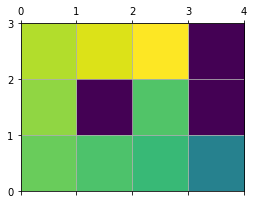

In [10]:
def Print_V(world_row=3,world_col=4):
    graph = ""
    for row in range(world_row):
        row_string = ""
        for col in range(world_col):
            row_string += str(round(V[One_index((row,col))],4))+' '
        row_string += '\n'
        graph += row_string 
    print(graph) 

Print_V()

def Return_V(world_row=3,world_col=4):
    graph = []
    for row in range(world_row):
        row_l = []
        for col in range(world_col):
            row_l.append(V[One_index((row,col))])
        graph.append(row_l)
    return graph 

plt.matshow(Return_V(),extent=[0, 4, 0, 3])
plt.grid()
plt.show()

V_exact = Return_V()

# 2- Evaluating the policy using value iteration

<img src="http://www.cs.upc.edu/~mmartin/VI.png" width="550">

In [11]:
error=[]
V = np.zeros((3,4))
delta=1000
while delta> 0.00001:
    old_V = V.copy()
    delta = 0
    state = np.nditer(state_matrix, flags=['multi_index'])
    while not state.finished:
        action = policy_matrix[state.multi_index]
        if state[0]==0:
            acum=0
            for x in zip(prob_next_state(state.multi_index,3,4),transition_matrix[int(action),:]):
                acum = acum + x[1]*(reward_matrix[x[0]]+gamma*old_V[x[0]])
            V[state.multi_index] = acum
        state.iternext()
    error.append(np.sum(V_exact - V))
    delta = np.max(abs(V_exact - V))
print(V)


[[ 0.84881224  0.90630541  0.95748948  0.        ]
 [ 0.79776395  0.          0.69906187  0.        ]
 [ 0.74042274  0.68950862  0.64536082  0.4219169 ]]


Plot how error decreases with number of iterations

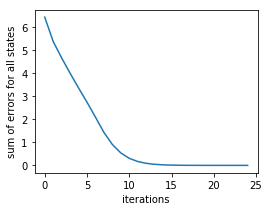

In [12]:
plt.plot(error)
plt.ylabel('sum of errors for all states')
plt.xlabel('iterations')
plt.show()